In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import os
import torchvision

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import re
import torchvision.models as models
from torchsummary import summary

In [ ]:
# Downloading dataset for Colab and creating the test and train folder so as to use the custom ImageFolder dataloader from pytorch

def download_dataset():
  !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
  !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
  !tar zxvf images.tar.gz
  !tar zxvf annotations.tar.gz
  %mkdir data
  %cd ./data/
  %mkdir test
  %mkdir train
  %cd ..


In [ ]:
# create directory if it does not exist

def check_dir(dir_path):
    dir_path = dir_path.replace('//','/')
    os.makedirs(dir_path, exist_ok=True)

In [ ]:
# Copying the images to the train and test folders according to the split specified in the test.txt and testval.txt annotation files

def createDatasetFolders(annotation_path,dest_path):
  with open(annotation_path) as fp:
    line = fp.readline()
    source = './images'
    dest = dest_path
    while line:
        f,_,_,_ = line.split(' ')
        line = fp.readline()
        pat = re.compile(r'_\d')
        res,_ = pat.split(f)
        
        source_path_test = os.path.join(source,f)
        source_path_test= source_path_test + '.jpg'
        dest_path_test = os.path.join(dest,res)
        check_dir(dest_path_test)
        dest_path_test = os.path.join(dest_path_test,f)
        dest_path_test= dest_path_test + '.jpg'
       
        shutil.copy(source_path_test,dest_path_test)


In [ ]:
def saving_model(model, optimizer, epoch, stats):
    if not os.path.exists("models"):
        os.makedirs("models")
    save_path = f"models/{model.name}_{epoch+1}.pth"
    print(save_path)
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, save_path)
    

def loading_model(model, path):
    optimizer = torch.optim.Adam(params=model.parameters(), lr= 3e-4)
    checkpoint =  torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    stats = checkpoint['stats']
    return model, optimizer, epoch, stats

In [ ]:
download_dataset()

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annotations/trimaps/pomeranian

In [ ]:
annotation_path_test = './annotations/test.txt'
dest_path_test = './data/test'
createDatasetFolders(annotation_path_test,dest_path_test)

In [ ]:
annotation_path_train = './annotations/trainval.txt'
dest_path_train = './data/train'
createDatasetFolders(annotation_path_train,dest_path_train)

In [ ]:
data_dir = 'C:/users/aysha/Cuda Lab/data/'

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

vgg_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

In [ ]:
animal_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), vgg_format)
         for x in ['train', 'test']}

In [ ]:
train_loader = DataLoader(animal_datasets['train'], batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(animal_datasets['test'], batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
dset_classes = animal_datasets['train'].classes
print("The number of classes of Dog and Cat Breeds are ",len(animal_datasets['train'].classes))


The number of classes of Dog and Cat Breeds are  37


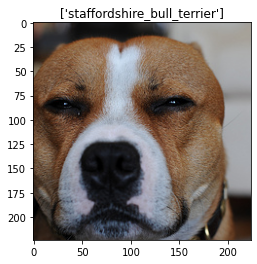

In [ ]:
# Visualizing a batch of testing data
inputs, classes = next(iter(test_loader))

n_images = 1

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

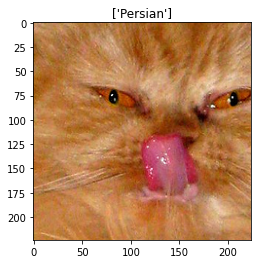

In [ ]:
# Visualizing a batch of training data
inputs, classes = next(iter(train_loader))

n_images = 1

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, allow_cutmix,device):
    """ Training a model for one epoch """
    
    loss_list = []
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    
    for idx, (images, labels) in pbar:
        if allow_cutmix:
            images, labels = generate_cutmix_image(images, labels, 1.0)
    
        # put on gpu
        images, labels = images.to(device), labels.to(device)
        model = model.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        running_loss =+ loss.item()
        
        if idx % 1 == 0:
            pbar.set_description(f"Epoch {epoch+1}, Itr {idx+1}, Loss {running_loss:.5f}")

    avg_loss = np.mean(loss_list)

    return avg_loss,loss_list

@torch.no_grad()
def eval_model(model, eval_loader, criterion,device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def training_model(model, optimizer,scheduler, criterion, train_loader, valid_loader, num_epochs, allow_cutmix):
    """ Training a model for a given number of epochs"""

    stats = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "valid_acc": [],
        "loss_iters":[]
    }
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval() 
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion,device=device
            )
        stats["valid_acc"].append(accuracy)
        stats["val_loss"].append(loss)
        
        # training epoch
        stats['epoch'].append(epoch+1)
        
        model.train() 
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, allow_cutmix=allow_cutmix, device=device
            )
        scheduler.step()
        stats["train_loss"].append(mean_loss)
        stats["loss_iters"] = stats["loss_iters"] + cur_loss_iters
        
        if epoch == 0 or (epoch+1) % 3 == 0 or (epoch+1) == num_epochs:
            #saving_model(model, optimizer, epoch, stats)
            print(f"Accuracy for epoch: {epoch+1} is ", stats["valid_acc"][-1])
            print("\n")
    
    print(f"Training completed")
    return model, stats

def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader_transforms):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, actual:{}'.format(dset_classes[preds[j]],dset_classes[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
data_transforms = { 'train':transforms.Compose([transforms.ToTensor(),
                        transforms.ColorJitter(brightness=.5, hue=.3),
                        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                        transforms.RandomRotation(5),
                        transforms.Resize((224, 224)),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       ]),
             'test' : transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((224, 224)),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])
             }

In [ ]:
animal_datasets_transforms = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'test']}

In [ ]:
train_loader_transforms = DataLoader(animal_datasets_transforms['train'], batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
test_loader_transforms = DataLoader(animal_datasets_transforms['test'], batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

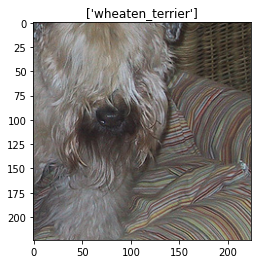

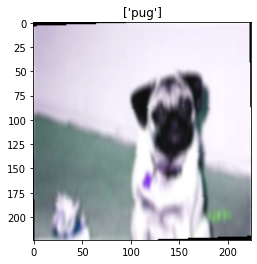

In [ ]:
#Visualizing the transformed images from the train dataset

# Get a batch of training data
inputs, classes = next(iter(train_loader_transforms))

n_images = 1

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

# Get a batch of training data
inputs, classes = next(iter(train_loader_transforms))

n_images = 1

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### With using resnet34 as a pretrained model, without any data augmentation and using a stepLR Schedular

In [ ]:
model = models.resnet34(pretrained=True)

num_ftrs=model.fc.in_features
model.fc=nn.Linear(num_ftrs,37)

model=model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

%time model_finetune_resnet_noaug, stats = training_model(model, optimizer, scheduler, criterion, train_loader, test_loader, 10, False)



Epoch 1, Itr 230, Loss 0.86064: 100%|████████████████████████████████████████████████| 230/230 [00:47<00:00,  4.85it/s]


Accuracy for epoch: 1 is  2.3984736985554647




Epoch 3, Itr 230, Loss 0.63452: 100%|████████████████████████████████████████████████| 230/230 [00:49<00:00,  4.65it/s]


Accuracy for epoch: 3 is  61.78795312074135




Epoch 6, Itr 230, Loss 0.07030: 100%|████████████████████████████████████████████████| 230/230 [00:50<00:00,  4.57it/s]


Accuracy for epoch: 6 is  64.64976832924503




Epoch 9, Itr 230, Loss 0.01240: 100%|████████████████████████████████████████████████| 230/230 [00:49<00:00,  4.61it/s]


Accuracy for epoch: 9 is  79.34041973289725




Epoch 10, Itr 230, Loss 0.11238: 100%|███████████████████████████████████████████████| 230/230 [00:51<00:00,  4.48it/s]

Accuracy for epoch: 10 is  80.53965658217498


Training completed
Wall time: 12min 56s


### With using resnet34 as a pretrained model, with data augmentation and using a stepLR Schedular

In [ ]:
model_finetune_resnet = models.resnet34(pretrained=True)

num_ftrs=model_finetune_resnet.fc.in_features
model_finetune_resnet.fc=nn.Linear(num_ftrs,37)


model_finetune_resnet=model_finetune_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_finetune_resnet.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

%time model_finetune_resnetStep, stats_augStep = training_model(model_finetune_resnet, optimizer, scheduler, criterion, train_loader_transforms, test_loader_transforms, 10, False)



Epoch 1, Itr 230, Loss 1.15712: 100%|████████████████████████████████████████████████| 230/230 [01:56<00:00,  1.97it/s]


Accuracy for epoch: 1 is  1.3355137639683836




Epoch 3, Itr 230, Loss 0.71005: 100%|████████████████████████████████████████████████| 230/230 [02:37<00:00,  1.46it/s]


Accuracy for epoch: 3 is  68.411011174707




Epoch 6, Itr 230, Loss 0.12079: 100%|████████████████████████████████████████████████| 230/230 [02:43<00:00,  1.40it/s]


Accuracy for epoch: 6 is  72.58108476424093




Epoch 9, Itr 230, Loss 0.04763: 100%|████████████████████████████████████████████████| 230/230 [02:45<00:00,  1.39it/s]


Accuracy for epoch: 9 is  80.2943581357318




Epoch 10, Itr 230, Loss 0.00722: 100%|███████████████████████████████████████████████| 230/230 [02:52<00:00,  1.33it/s]

Accuracy for epoch: 10 is  82.06595802671028


Training completed
Wall time: 31min 8s


### With using resnet34 as a pretrained model, with data augmentation and using a ExponentialLR Schedular

In [ ]:
model_finetune_resnet = models.resnet34(pretrained=True)

num_ftrs=model_finetune_resnet.fc.in_features
model_finetune_resnet.fc=nn.Linear(num_ftrs,37)

model_finetune_resnet=model_finetune_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_finetune_resnet.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)

%time model_finetune_resnetExp, stats_augExp= training_model(model_finetune_resnet, optimizer, scheduler, criterion, train_loader_transforms, test_loader_transforms, 10, False)



Epoch 1, Itr 230, Loss 1.13451: 100%|████████████████████████████████████████████████| 230/230 [02:55<00:00,  1.31it/s]


Accuracy for epoch: 1 is  2.9708367402562006




Epoch 3, Itr 230, Loss 1.20882: 100%|████████████████████████████████████████████████| 230/230 [02:55<00:00,  1.31it/s]


Accuracy for epoch: 3 is  69.99182338511855




Epoch 6, Itr 230, Loss 0.20688: 100%|████████████████████████████████████████████████| 230/230 [02:41<00:00,  1.42it/s]


Accuracy for epoch: 6 is  74.48896156991006




Epoch 9, Itr 230, Loss 0.02845: 100%|████████████████████████████████████████████████| 230/230 [02:44<00:00,  1.40it/s]


Accuracy for epoch: 9 is  75.11583537748704




Epoch 10, Itr 230, Loss 0.02651: 100%|███████████████████████████████████████████████| 230/230 [02:43<00:00,  1.41it/s]

Accuracy for epoch: 10 is  73.94385391114746


Training completed
Wall time: 33min 40s


**We achieve the best results using a pretrained resnet34 model, with data augmentation (Jitter, random horizontal flips, crops and gaussian blur) and a stepLR schedular for learning rate with an accuracy of 82%**

### Visualizing the results of the best model

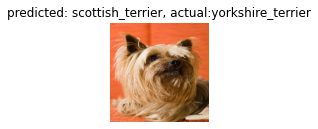

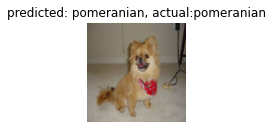

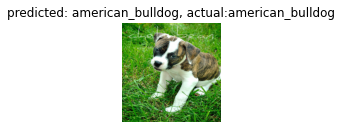

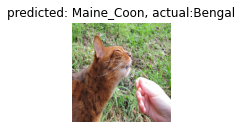

In [ ]:
visualize_model(model_finetune_resnetStep)

Here we can see that the predictions are correct for pomeranian and american bulldog. For the other two the predictions are wrong ,here in both cases the animals are not completely visible in the images, this might be the reason for the incorrect predictions. It is also worth noting that the scottish terrier and the yorkshire terrier share a lot of physical attributes.

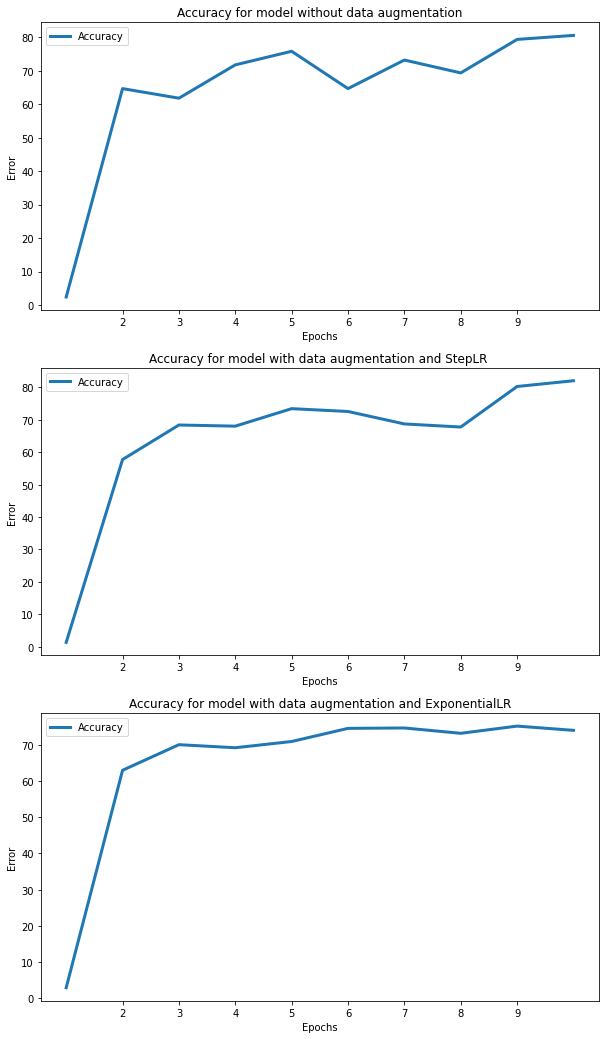

In [ ]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(10, 18)

ax[0].plot(stats['epoch'], stats['valid_acc'], label="Accuracy", linewidth=3)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_xticks(np.arange(2, 10, step=1))

ax[0].set_title("Accuracy for model without data augmentation")

ax[1].plot(stats_augStep['epoch'], stats_augStep['valid_acc'], label="Accuracy", linewidth=3)
ax[1].legend(loc='best')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_xticks(np.arange(2, 10, step=1))

ax[1].set_title("Accuracy for model with data augmentation and StepLR ")

ax[2].plot(stats_augExp['epoch'], stats_augExp['valid_acc'], label="Accuracy", linewidth=3)
ax[2].legend(loc='best')
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy")
ax[2].set_xticks(np.arange(2, 10, step=1))

ax[2].set_title("Accuracy for model with data augmentation and ExponentialLR")


plt.show()

## References
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html